# First draft
It is just working!

# To Do

 - clean the code
 - explain the code step by step
 - optimize the implementation
 - add plots
 - make it work on data format from Kaggle
 - make it work on any rating data
 

In [1]:
"""   Collaborative filtering algorithm to predict user ratings for films, based on previous ratings in netflix dataset
 ---  2018, AliSaaalehi@gmail.com 
 ---  subset of Netflix dataset is used. Look at the "description.txt" for more info on dataset
 """

import csv
import time 
import math
import pdb
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

# Read dataset
First thing first! Let's read the dataset. If you look at the "netflix" folder, you will find three files there. description.txt explains the dataset. I am summarizing it here:

- This dataset is a small subset of the data provided as part of the Netflix Prize.
- Each row in the **ratings.txt** file represents a rating of a movie by some user. Its format is:<br>
   `MovieID, UserID, Rating` for example: `3740, 1502539, 3.0` <br> Ratings are integers from 1 to 5. 
- The file **movie_titles.txt** contains information about movies. Its rows have the format:<br>
  `MovieID ,YearOfRelease ,Title` for example: `9428,2001,Friend` <br> Note that it contains many more movies than have been mentioned in ratings.txt
  
  
I will create a dictionary called `movie_titles_dict` to store information about movies. Key is movie id and the year and title of the move with together will be values in this dictionary.

The numpy array `ratings` contains all the rows of the *ratings.txt*

In [24]:
# Read movie_titles.txt and store info in a dictionary
with open('./netflix/movie_titles.txt', 'r') as file_handle: # , encoding ='ISO-8859-1'
    data_reader = csv.reader(file_handle, delimiter=',')
    movie_titles_dict = dict()
    for row in data_reader:
        description = [row[1]] # year of the movie
        description.append(row[2]) # append title to this
        key = float(row[0]) # key is movie id
        movie_titles_dict[key] = description

# Read ratings.txt 
with open('./netflix/ratings.txt', 'r') as file_handle:
    data_reader = csv.reader(file_handle, delimiter=',')
    ratings = []
    for row in data_reader:
        ratings.append(list(map(float,row)))
# convert it to numpy array
ratings=np.asarray(ratings)

<a id="trick-section"> </a>
# One important trick!

At one point in the code, I want to create a big matrix in which each row corresponds to one user and columns will represent different movies. The values inside the matrix are representing the rates that each user has given to each movie. 

For example, if the user with id 7 has given the rate 5 for the movie with id 28, the cell in matrix related to user 7 and movie 28 will be filled with 5. Lets call this matrix **users_movies**.

I will put zeros in those elements that are not specified.



users_movies = <img src="./imgs/um.png">

If you look at the all user ids and move ids in the file **ratings.txt** you will notice that we do not have ratings for all users and all the movies. First movie id is 28 and the next available one in the dataset is 48 and the last one is 17137. In case of users, first user id is 7 and the last one is $2649267$. 

Imagine what would be the size of the matrix if we create the matrix with the number of rows equal to maximum user id which is $2649267$ and the number of rows equal to maximum movie id which is $17137$. So, the matrix would be $2649267 \times 17137$. This matrix would have $45400488579$ elements! If each element takes one byte in the ram, it will require about 45 Gigabyte just to store this matrix!

We can easily make it much smaller, by using just those ids that are present in the dataset, but there is a small problem. Later in the code, we need to refer to the elements inside this matrix, but with the new matrix, we can not do this kind of indexing. For example we can not access it in this way: *a = users_movies[user_id, movie_id]* because for example rates that the user_id 7 has given to movies are stored in the first row of the matrix not in the $user\_id^{th}$ row of it, so we need a fast way to know that user_id 7 corresponds to the first row of the matrix and as another example, rates related to movie_id 48 are stored in the second column of the matrix.

For this purpose, I will create dictionaries to make this correspondence happen easily and quickly.
- **users_d** is a dictionary in which the key is user id and the value is row number in the matrix **users_movies** that stores ratings given by this user. For example `users_d[7]` will be 0, and `users_d[79]` is 1.
- **movies_d** is a dictionary in which the key is movie id and the value is column number in the matrix **users_movies** that is correspondent to this movie. For example `movies_d[28]` is 0 and `movies_d[17137]` is 91.

Let's do the real work:


In [34]:
# create a dictionary to map user ids to indexes
user_unique=np.unique(ratings[:,1])
users_num=user_unique.size
users_d={x:y for x,y in zip(user_unique,range(users_num))} # user dictionary
# print some info
print("Number of users: ", users_num)
print("First five user ids: ", user_unique[0:5])
print("Last five user ids: ", user_unique[-6:-1])
print('users_d[7]: ', users_d[7])
print('users_d[2649267]: ', users_d[2649267])


# create a dictionary to map movie ids to indexes
movie_unique=np.unique(ratings[:,0])
movies_num=movie_unique.size
movies_d={x:y for x,y in zip(movie_unique,range(movies_num))} # movie dictionary
# print some info
print("Number of movies: ", movies_num)
print("First five movie ids: ", movie_unique[0:5])
print("Last five movie ids: ", movie_unique[-6:-1])
print('movies_d[28]: ', movies_d[28])
print('movies_d[2649267]: ', movies_d[17137])

('Number of users: ', 28968)
('First five user ids: ', array([  7.,  79., 199., 481., 769.]))
('Last five user ids: ', array([2648853., 2648869., 2648885., 2649120., 2649267.]))
('users_d[7]: ', 0)
('users_d[2649267]: ', 28966)
('Number of movies: ', 92)
('First five movie ids: ', array([ 28.,  48., 305., 577., 595.]))
('Last five movie ids: ', array([15992., 16082., 16576., 16820., 16933.]))
('movies_d[28]: ', 0)
('movies_d[2649267]: ', 91)


# Shuffle the ratings
In the **ratings.txt** rows are sorted based on movie ids in the dataset. I'm going to separate the test and train data, so it is better to shuffle them before doing so.

In [6]:
# shuffle the ratings
np.random.shuffle(ratings)

# Separate test data for evaluation
We have $227773$ triplets of `MovieID, UserID, Rating`. I am going to put aside one percent of them that is exactly 227 of them for future tests.

In [37]:
# separate test and train data
# be careful, dictionaries should be created before separating test and train!

ratings_num=ratings.shape[0]
print("Number of ratings: ", ratings_num)

test_percentage = 0.1
test_num= int(math.floor(test_percentage*ratings_num/100))
print("Number of test samples: ", test_num)

test_ratings=ratings[0:test_num,:]
train_ratings=ratings[test_num+1:-1,:]

print("First few train ratings: ", train_ratings[0:10,:])
print("First few test ratings: ", test_ratings[0:10,:])

('Number of ratings: ', 227773)
('Number of test samples: ', 227)
('First few train ratings: ', array([[2.800000e+01, 1.148490e+06, 5.000000e+00],
       [2.800000e+01, 1.951605e+06, 2.000000e+00],
       [2.800000e+01, 1.363333e+06, 5.000000e+00],
       [2.800000e+01, 1.654137e+06, 4.000000e+00],
       [2.800000e+01, 2.522070e+05, 4.000000e+00],
       [2.800000e+01, 2.619959e+06, 3.000000e+00],
       [2.800000e+01, 1.861514e+06, 3.000000e+00],
       [2.800000e+01, 1.362000e+04, 5.000000e+00],
       [2.800000e+01, 2.598622e+06, 4.000000e+00],
       [2.800000e+01, 1.310250e+06, 3.000000e+00]]))
('First few test ratings: ', array([[2.800000e+01, 1.392773e+06, 4.000000e+00],
       [2.800000e+01, 1.990901e+06, 5.000000e+00],
       [2.800000e+01, 7.653310e+05, 3.000000e+00],
       [2.800000e+01, 1.987434e+06, 4.000000e+00],
       [2.800000e+01, 2.193455e+06, 4.000000e+00],
       [2.800000e+01, 1.468812e+06, 4.000000e+00],
       [2.800000e+01, 4.141200e+04, 4.000000e+00],
      

# Create and fill up the users_movies matrix
Now, let's create the **users_movies** matrix that we discussed in the section [One important trick](#trick-section)

('Shape of the users_movies matrix: ', (28968, 92))
('Number of zero element of the matrix: ', 2437512)
('Sparsness of the matrix: ', 91.0, '%')


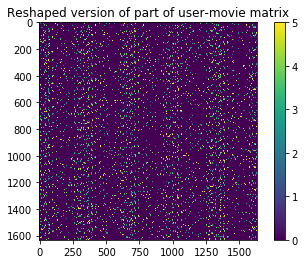

In [48]:
# creat users-movies matrix
users_movies=np.zeros((users_num,movies_num),dtype=int)

for row in train_ratings:
    m_index=movies_d[row[0]]
    u_index=users_d[row[1]]
    users_movies[u_index,m_index]=row[2]

# let's print and plot some information about the users_movies matrix
print("Shape of the users_movies matrix: ", users_movies.shape)
zero_num=users_movies.size - np.count_nonzero(users_movies)
print("Number of zero element of the matrix: ", zero_num)
print("Sparsness of the matrix: ", (math.floor(float(zero_num) / users_movies.size*100)), "%")

# reshape and plot the matrix like an image
plot_flag = True
if plot_flag == True:
    plt.imshow(users_movies.reshape(1632,1633))
    plt.colorbar()
    plt.title("Reshaped version of part of user-movie matrix")
    plt.show()
        

In [18]:
# mesaure averag
users_sum_ratings = np.sum(users_movies, axis=1)
nonzero_nums= np.count_nonzero(users_movies, axis=1)
users_avg_ratings = np.zeros(users_sum_ratings.shape, dtype=float)

# to avoid division by zero
#proper_inds = nonzero_nums>0
for i in range(users_sum_ratings.size):
    if nonzero_nums[i]!=0:
        users_avg_ratings[i] = users_sum_ratings[i] / nonzero_nums[i]
        
print("Number of users with zero average ratings: " , users_avg_ratings.size - np.count_nonzero(users_avg_ratings))
s=-10
e=-1
print(users_sum_ratings[s:e])
print(nonzero_nums[s:e])
print(users_avg_ratings[s:e])
#plt.imshow(users_avg_ratings[0:28900].reshape(170,170))
#plt.colorbar()
#plt.show()

('Number of users with zero average ratings: ', 0)
[14 24 33 18 20 20 37 20 19]
[4 8 9 5 8 6 9 5 6]
[3. 3. 3. 3. 2. 3. 4. 4. 3.]


In [19]:
#Normalize rates by the users average weight

print (users_movies[1,:])

non_zero_um= np.zeros(users_movies.shape, dtype=int)
non_zero_um[users_movies>0]=1

users_movies_normalized = np.subtract(users_movies,users_avg_ratings[:,None])
users_movies_normalized = np.multiply(users_movies_normalized,non_zero_um)


[0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0
 0 0 0 0 0 0 3 5 0 0 0 0 0 4 0 0 0 0]


In [20]:
tic = time.time()
# form a matrix containing the number of common movies between users
common_matrix=np.matmul(non_zero_um , non_zero_um.T)

print("processing time: ", time.time()-tic)

('processing time: ', 54.82439684867859)


In [21]:
def predict_rating(user_index, movie_index, min_common_movies=2):
     
    # Look at the row of the common_matrix which shows number of common movies between this user and all other users in the dataset
    # Then filter those that have more than specific number of common movies rated
    common_row = common_matrix [user_index,:]
    similar_users= (np.where( common_row > min_common_movies))[0] # The function np.Where() returns results in the form of tuple, we need the
                                                      #  list of indexes which in in the first lement of that tuple
    
    active_user_ratings = users_movies_normalized [user_index,:] # Remember these are normalized ratings, we do not need to subtract average to normalize them
    
    number_of_similar_users = similar_users.size
    similarity_list = np.zeros((number_of_similar_users,1), dtype=float) # Empty list to store similarity measures (all w(a,i) from equation (2))
    
    if (number_of_similar_users == 0):
        print ('No smilar user in the dataset found! ')
        print ('Averge rating for the user is returned! ')
        predicted_rate = users_avg_ratings[user_index]
        return predicted_rate
    
   
    for i in range(number_of_similar_users):
        current_similar_user_index = similar_users [i]
        current_similar_user_ratings = users_movies_normalized [current_similar_user_index,:]

        # Numinator of the equation (2): sum of product of active users normalized rating with all similar users
        numinator= np.matmul(active_user_ratings.T , current_similar_user_ratings)
        
        # Denominator part: To avoid foor loops I will using logical operations
        number_of_movies = active_user_ratings.size
        denuminator_1 = 0
        denuminator_2 = 0

        for j in range(number_of_movies):
            if active_user_ratings[j] !=0 and current_similar_user_ratings[j] !=0:
                denuminator_1 += (active_user_ratings[j] **2)
                denuminator_2 += (current_similar_user_ratings[j] **2)
        denuminator = math.sqrt(denuminator_1 * denuminator_2)

        # Avoid division
        if denuminator == 0:
            similarity_list[i] = 0
        else:
            similarity_list[i] = numinator / denuminator      
        
    
    # Finally sum up every thing and mesure predicted rate
    sigma_part = 0
    for i in range(number_of_similar_users):
        current_similar_user_index = similar_users [i]
        sigma_part = users_movies_normalized [current_similar_user_index, movie_index] * similarity_list[i]
    
    
    normalization_factor = np.sum(np.absolute(similarity_list))
    predicted_rate= users_avg_ratings[user_index]
    
    if normalization_factor !=0:
        predicted_rate +=  sigma_part / normalization_factor
        
    # Finall sanity checks (This will not happen hopefully)
    if predicted_rate > 5: 
        predicted_rate = 5 
    elif predicted_rate < 0:
        predicted_rate = 0
    
    return predicted_rate

In [22]:
error = 0
num = 5
for r in range(num):

    row = test_ratings[r,:]
    movie_id = movies_d[row[0]]
    test_user_id = users_d[row[1]]
    real_rate=row[2]
    predicted_rate = predict_rating(test_user_id, movie_id, min_common_movies = 0)
    print('--------------------------------------------------')
    print('user r: ',r,'   Predicted Rate=' + str(predicted_rate))
    print('             Real rate= '+ str(real_rate))
    error += (predicted_rate - real_rate) ** 2


print ('MSE: ', error / num)

--------------------------------------------------
('user r: ', 0, '   Predicted Rate=[3.00001905]')
             Real rate= 2.0
--------------------------------------------------
('user r: ', 1, '   Predicted Rate=[2.]')
             Real rate= 3.0
--------------------------------------------------
('user r: ', 2, '   Predicted Rate=[4.]')
             Real rate= 4.0
--------------------------------------------------
('user r: ', 3, '   Predicted Rate=[4.00005535]')
             Real rate= 5.0
--------------------------------------------------
('user r: ', 4, '   Predicted Rate=[2.]')
             Real rate= 4.0
('MSE: ', array([1.39998548]))


In [23]:
while True:
    
    quary_user_id = 160977
    quary_year= '2004'

    quary_user_id =  int(input('Enter a valid user id: '))
    quary_year = input ('Enter the desired year: ')

    min_rate_threshold = 3
    test_user_index = users_d[quary_user_id]
    print ('*** Recommended movies ***')
    for m in movie_unique:
        movie_index = movies_d[m]
        #print (movie_titles_dict[m][0])

        if  users_movies[test_user_index, movie_index]==0 and movie_titles_dict[m][0] == quary_year:
            predicted_rate = predict_rating(test_user_id, movie_id, min_common_movies = 2)
            if predicted_rate >= min_rate_threshold:
                print(movie_titles_dict[m][1])
    print ('*** ------------------ ***')
    
    if input('press q to exit or anything to try again')=='q':
        break

Enter a valid user id: 160977
Enter the desired year: 2011
*** Recommended movies ***
*** ------------------ ***
press q to exit or anything to try againq


NameError: name 'q' is not defined

# Reference

“Empirical analysis of Predictive Algorithms for Collaborative Filtering by John S. Breese et al. 1998”